#### [Exp_03] 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

1. 필요 라이브러리 import 및 데이터 준비.

In [2]:
# 관련 라이브러리 로드.

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import VotingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# for split dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # 더 높은 해상도로 출력한다.


train data dim : (15035, 21)
sub data dim : (6468, 20)
컬럼: id : 결측치: 0
컬럼: date : 결측치: 0
컬럼: bedrooms : 결측치: 0
컬럼: bathrooms : 결측치: 0
컬럼: sqft_living : 결측치: 0
컬럼: sqft_lot : 결측치: 0
컬럼: floors : 결측치: 0
컬럼: waterfront : 결측치: 0
컬럼: view : 결측치: 0
컬럼: condition : 결측치: 0
컬럼: grade : 결측치: 0
컬럼: sqft_above : 결측치: 0
컬럼: sqft_basement : 결측치: 0
컬럼: yr_built : 결측치: 0
컬럼: yr_renovated : 결측치: 0
컬럼: zipcode : 결측치: 0
컬럼: lat : 결측치: 0
컬럼: long : 결측치: 0
컬럼: sqft_living15 : 결측치: 0
컬럼: sqft_lot15 : 결측치: 0


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


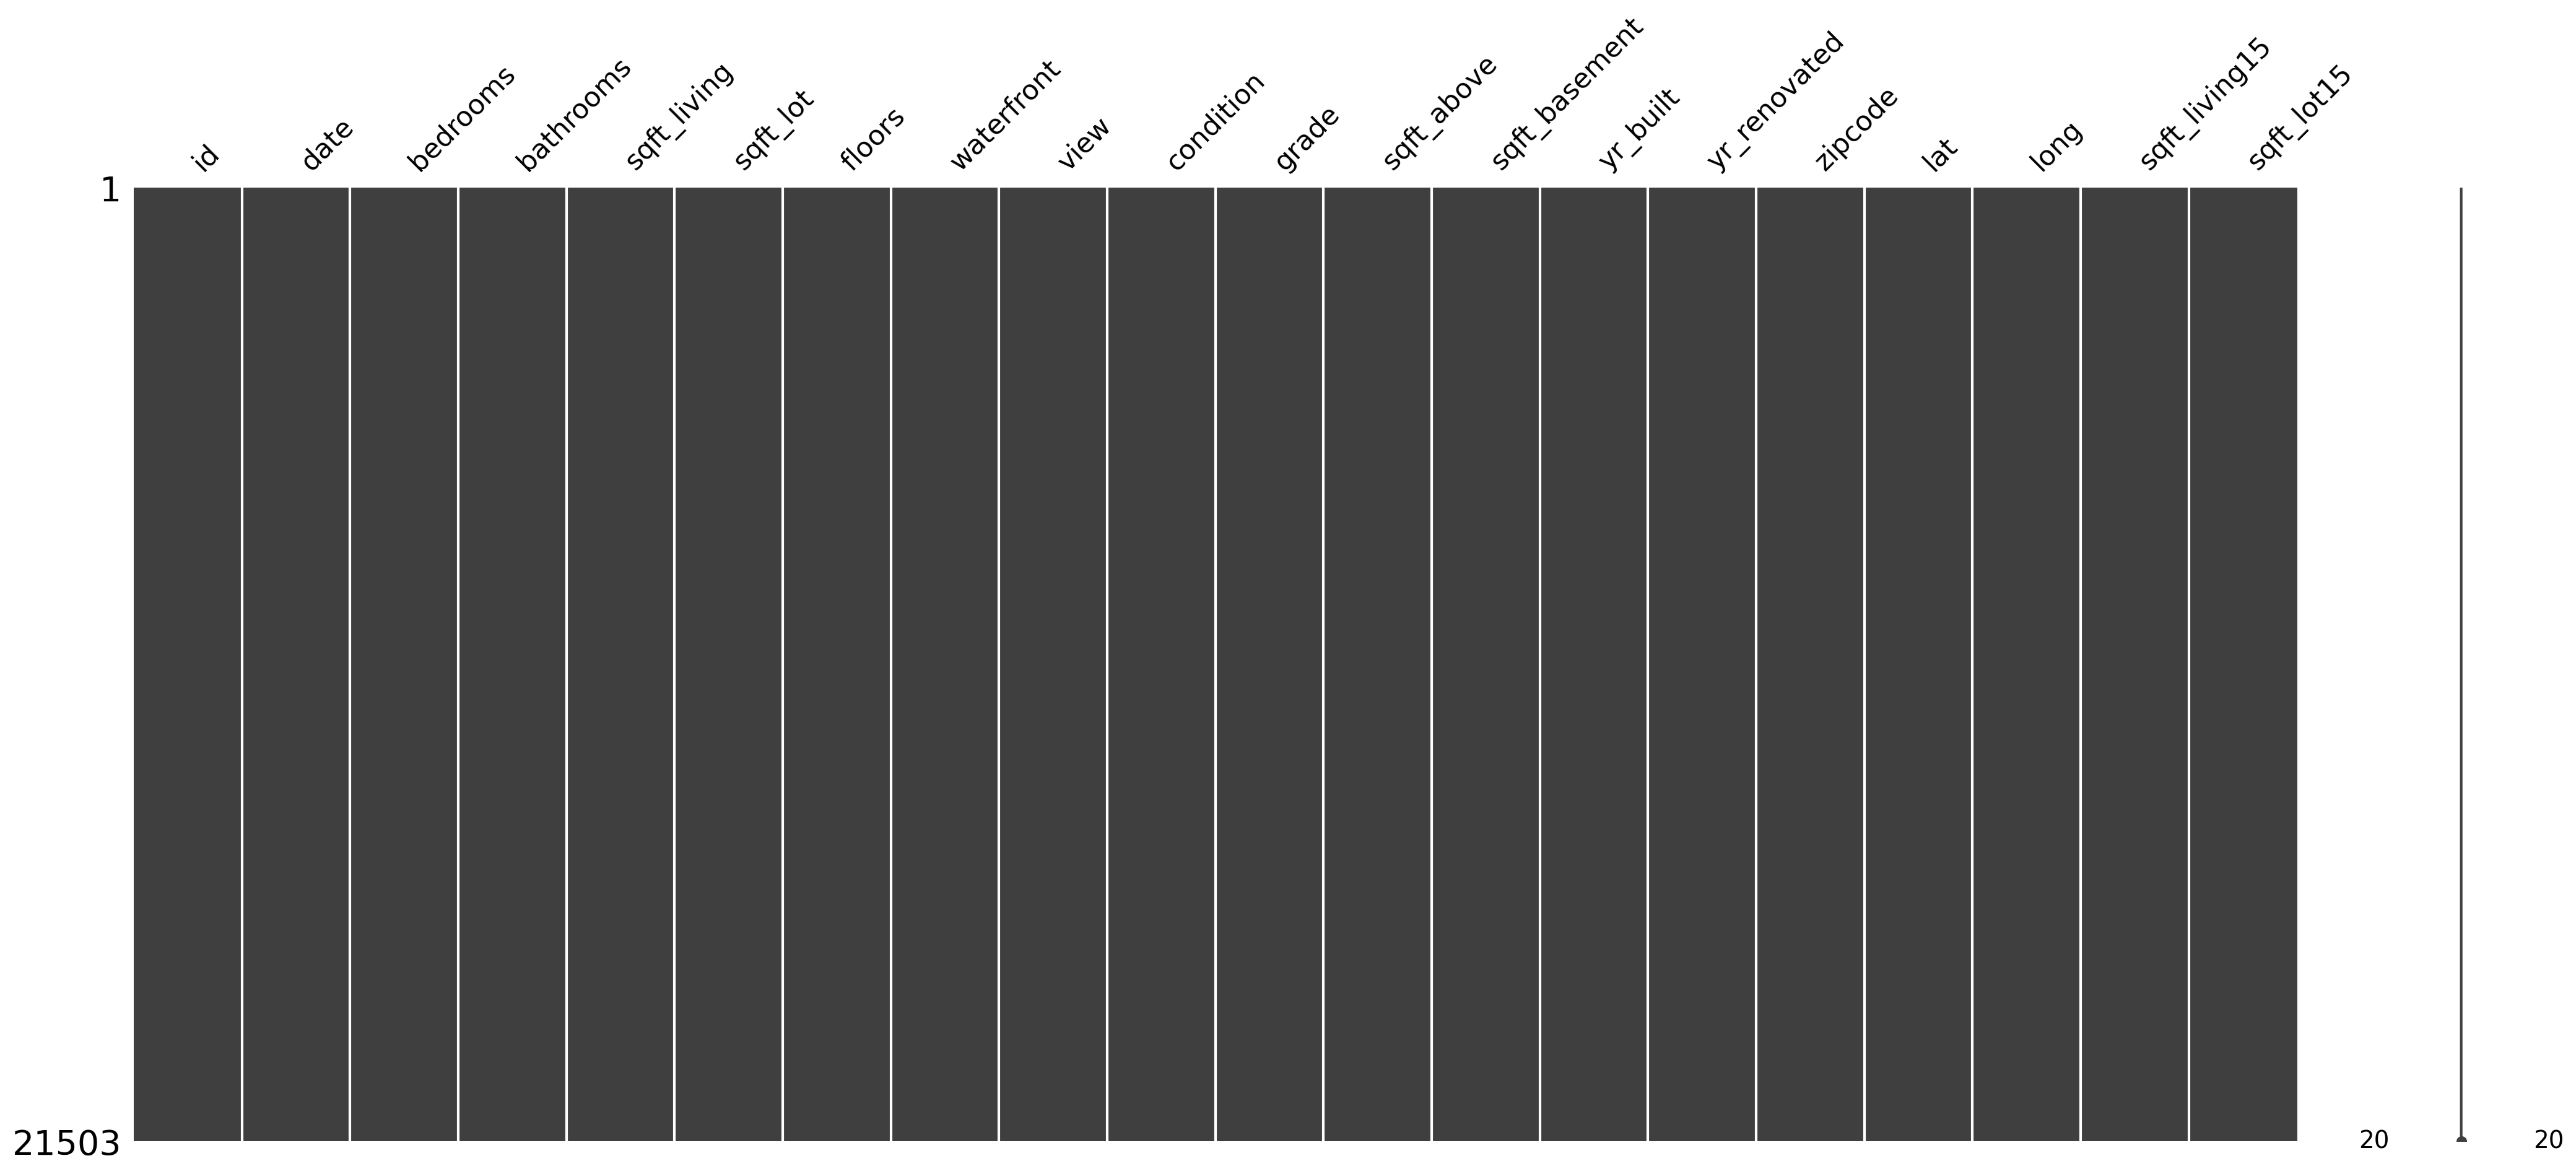

In [3]:
# data폴더 위치 지정.
data_path = "../data/exp03/"
train_data_path = join(data_path, 'train.csv')
test_data_path = join(data_path, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

# train데이터 크기 저장.
train_len = train.shape[0]

# sub id 저장.
sub_id = test['id']

# 라벨을 저장.
y = train['price']

# 라벨 컬럼을 제거.
del train['price']

# train, test를 data로 합쳐서 전처리함.
data = pd.concat([train, test], axis=0)

# 결측치 없음
msno.matrix(data)

# 1. 컬럼이 결측치인지 확인합니다.
for c in data.columns:
    print('컬럼: {} : 결측치: {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

# id column삭제.
del data['id']

# date ymd사용
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

# exp node의 내용을 바탕으로, log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들기.
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

log_y = np.log1p(y)

# baseline까지 정리된 데이터를 보관.
data_copy = data.copy()

data.head()

2. Exp-node에서 확인한 데이터 치우침 문제를 로그 적용하여 개선.

Text(0.5, 1.0, 'log y')

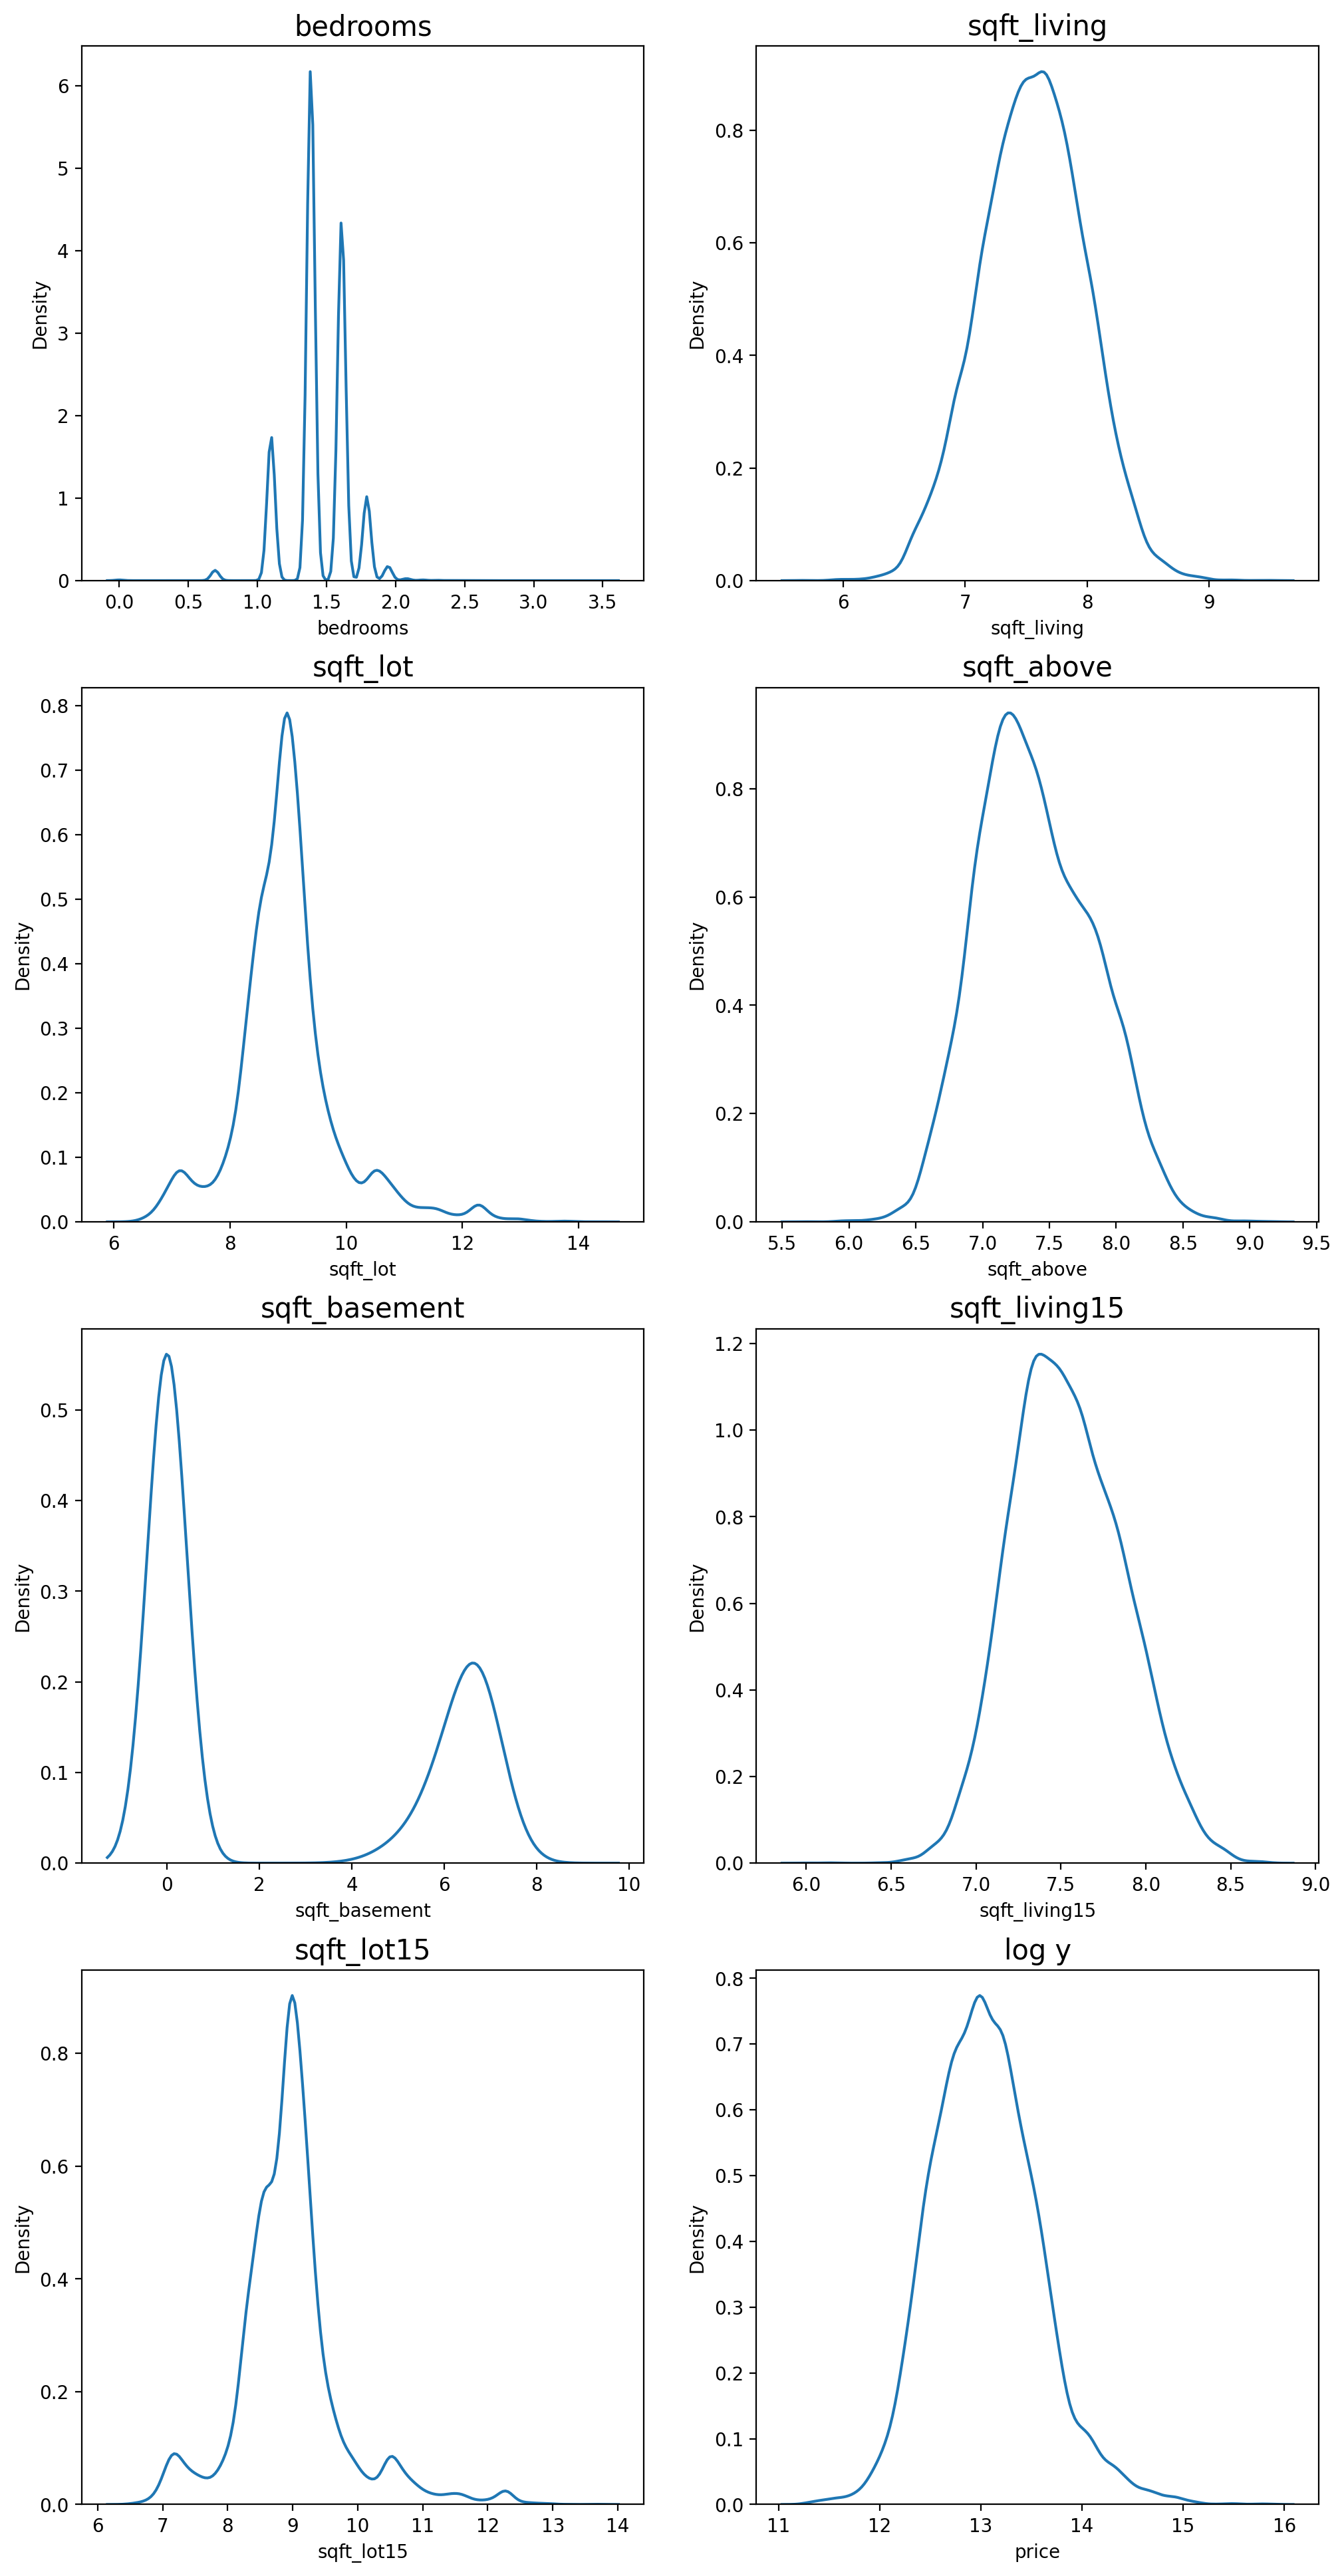

In [10]:
# log scale한 변수들 분포 확인.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 24))
flatten_axes = axes.flatten()

for idx, col in enumerate(skew_columns):
    axie=flatten_axes[idx]
    sns.kdeplot(data=data[col], ax=axie)
    axie.set_title(col, fontsize=15)

axie=flatten_axes[7]
sns.kdeplot(data=log_y, ax=axie)
axie.set_title("log y", fontsize=15)

3. 데이터 전처리.  
+ 날짜와, 규모, 경관, 지역, 등급 으로 크게 분류함.  
+ TODO: 각 분류별로 합산된 형태의 등급을 추가해보면 좋을듯 합니다.  

In [4]:
# 반복 테스트를 위해 원본 데이터 복구.
data = data_copy.copy()

# 추가 feature 생성 및 전처리.

## 날짜
# 'date'를 'date'를 date_y, date_m  int로 변경.
data['date_y'] = data['date'].apply(lambda i: i[:4]).astype(int)
data['date_m'] = data['date'].apply(lambda i: i[4:6]).astype(int)
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

# renovated 컬럼 추가.
data['renovated'] = data.yr_renovated != 0
data['renovated'] = data['renovated'].astype(int)

data['built'] = data.apply(lambda x : x['date_y'] - x['yr_built'], axis=1)
data['built'] = data['built'].astype(int)

data['rebuilt'] = data.apply(lambda x : x['date_y'] - x['yr_renovated'] if x['renovated'] == 1 else 0, axis=1)
data['rebuilt'] = data['built'].astype(int)

data = pd.get_dummies(data, columns=['date'])
del data['date_y']
del data['date_m']
# date 컬럼 삭제.
# del data['date']
# del data['date_y']

# data = pd.get_dummies(data, columns=['date_y', 'date_m'])

# date 컬럼 삭제.
# del data['date']
# # del data['date_y']
del data['yr_renovated']
del data['yr_built']

## 규모
# # 층별 bed, bath bed_bath 컬럼 추가., floors는 0 보다 큼. bedrooms, bathrooms는 0값있음.
data['bed_floor'] = round(data.bedrooms * 10/ data.floors , 0)
data['bath_floor'] = round(data.bathrooms * 10 / data.floors , 0)
data['bed_floor'] = data['bed_floor'].astype(int)
data['bath_floor'] = data['bath_floor'].astype(int)
data = pd.get_dummies(data, columns=['bed_floor', 'bath_floor', 'floors'])
# data['bed_bath'] = round(data.bedrooms * 10/ data.bathrooms , 0)
data['basement_y'] = data.sqft_basement != 0
data['basement_y'] = data['basement_y'].astype(int)

## 경관
data['view_good'] = data.view > 0
data['view_good'] = data['view_good'].astype(int)
data = pd.get_dummies(data, columns=['view'])

## 지역적 위치
data['zipcode_s'] = data['zipcode'].astype(str) # 임시 데이터
data['zipcode_sec'] = data['zipcode_s'].apply(lambda i: i[1:3]).astype(int)
data['zipcode_apo'] = data['zipcode_s'].apply(lambda i: i[3:5]).astype(int)
data = pd.get_dummies(data, columns=['zipcode_sec'])
data = pd.get_dummies(data, columns=['zipcode_apo'])

del data['zipcode']
del data['zipcode_s']
# del data['zipcode_apo']

# lat, long column은 구간 나누기시 점수가 더떨어지므로 제외.

## 등급
data = pd.get_dummies(data, columns=['condition', 'grade'])

print(f"preprocessed({len(data.columns)} columns)")
# print(data.head())


preprocessed(184 columns)


In [11]:
# model random 고정.
random_state = 2019

# 가격 항목 있으면 삭제
if 'price' in data.columns.values:
    del data['price']

# 전처리된 data에서 train과 test를 분리함.
X = data.iloc[:train_len, :]
sub_x = data.iloc[train_len:, :]

# for Test use small dataset.
test_count = 50
XX = data.iloc[:test_count, :]
yy = y[:test_count]
log_yy = log_y[:test_count]
sub_xx = data.iloc[train_len:train_len+test_count, :]


4. GridSearch를 통한 최적의 파라메타 찾기.

In [10]:
# Grid Search를 통하여 최적의 hyper parameter를 얻는다.

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=20, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results


param_grid = {
    'n_estimators': [50, 5000],
    'max_depth': [1, 20],
    'learning_rate' : [0.001, 0.1]
}

model = LGBMRegressor()
my_GridSearch(model, X, y, param_grid, verbose=0, n_jobs=4)

# 	learning_rate	max_depth	n_estimators	score	RMSLE
# 7	0.100	20	5000	-1.728681e+10	131479.295448
# 3	0.001	20	5000	-1.786510e+10	133660.405028
# 6	0.100	20	50	-1.788525e+10	133735.746811
# 5	0.100	1	5000	-2.284087e+10	151131.970940
# 4	0.100	1	50	-4.888245e+10	221093.756832
# 1	0.001	1	5000	-4.984560e+10	223261.271638
# 2	0.001	20	50	-1.285161e+11	358491.444403
# 0	0.001	1	50	-1.340436e+11	366119.663186

,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.100,20,5000,-1.728681e+10,131479.295448
3,0.001,20,5000,-1.786510e+10,133660.405028
6,0.100,20,50,-1.788525e+10,133735.746811
5,0.100,1,5000,-2.284087e+10,151131.970940
4,0.100,1,50,-4.888245e+10,221093.756832
1,0.001,1,5000,-4.984560e+10,223261.271638
2,0.001,20,50,-1.285161e+11,358491.444403
0,0.001,1,50,-1.340436e+11,366119.663186


5. 모델 학습 및 오차 평가.  
+ 전처리된 데이터를 기준으로 오차 평가하여 전처리 과정을 확인함.

In [6]:
# log여부를 반영한 rmse
def rmse(y_test, y_pred, logged=False):
    if logged:
        return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    else:
        return np.sqrt(mean_squared_error(y_test, y_pred))


# 선택한 모델로 학습 시키고, 오차(rmse)를 확인.
def model_learning(models, X, y, logged_y=False):
    
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        score = rmse(y_test, y_pred, logged_y)

        print(model_name, " rmse score:", score )

        df[model_name] = score

        if logged_y :
            y_pred = np.expm1(y_pred)

        # data frame에 저장(df가 dict 형이어서 copy동작이 되어 df데이터가 score_df에 누적됨.)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)


    return score_df


6. 앙상블 기법 구현.  
+ AveragingBlending 과 Voting기법.

In [7]:
# 앙상블 Averaging기법.
def AveragingBlending(models, X, y, sub_x, logged_y):
    
    predictions = None

    # # 모델 학습
    model_learning(models, X, y, logged_y=logged_y)
    
    for model in models : 
        
        model_name = model.__class__.__name__

        # 예측
        y_pred = model.predict(sub_x)
        
        if logged_y:
            y_pred = np.expm1(y_pred)
        
        if predictions is None:
            predictions = np.array(y_pred)
        else :
            predictions = np.vstack([predictions, np.array(y_pred)])
            
    return np.mean(predictions, axis=0)


# 앙상블 Voting모델.
def VotingModels(models, X, y, sub_x, logged_y):
    
    er = VotingRegressor([(model.__class__.__name__+str(i), model) for i, model in enumerate(models) ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    estimator = er.fit(X, y)

    # 예측
    y_pred = estimator.predict(sub_x)
    
    if logged_y :
        y_pred = np.expm1(y_pred)

    return y_pred
    
    

7. 학습 및 submission 테스트.

In [16]:
# main 코드 시작.

# GridSearch 결과값.
# 	learning_rate	max_depth	n_estimators	score	RMSLE
# 7	0.100	20	5000	-1.728681e+10	131479.295448
# 3	0.001	20	5000	-1.786510e+10	133660.405028
# 6	0.100	20	50	-1.788525e+10	133735.746811
# 5	0.100	1	5000	-2.284087e+10	151131.970940
# 4	0.100	1	50	-4.888245e+10	221093.756832
# 1	0.001	1	5000	-4.984560e+10	223261.271638
# 2	0.001	20	50	-1.285161e+11	358491.444403
# 0	0.001	1	50	-1.340436e+11	366119.663186

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm0 = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=5000, random_state=random_state)
lightgbm1 = LGBMRegressor(learning_rate=0.001, max_depth=20, n_estimators=5000, random_state=random_state)
lightgbm2 = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=50, random_state=random_state)
lightgbm3 = LGBMRegressor(learning_rate=0.1, max_depth=1, n_estimators=5000, random_state=random_state)
lightgbm4 = LGBMRegressor(learning_rate=0.1, max_depth=1, n_estimators=50, random_state=random_state)

models = [gboost, xgboost, lightgbm0]

# for model_learning test.
# model_learning(models, X, log_y, logged_y=True)

# 테스트 설정.
use_small_data = False
use_logged_y = False

X_t = None
y_t = None
x_t = None

if use_small_data : 
   if use_logged_y :
        X_t = XX
        y_t = log_yy
        x_t = sub_xx
   else:
        X_t = XX
        y_t = yy
        x_t = sub_xx
else:
    if use_logged_y:
        X_t = X
        y_t = log_y
        x_t = sub_x
    else:
        X_t = X
        y_t = y
        x_t = sub_x
        
# Select AveragingBlending, VotingModels
# not logged data사용시 kaggle private point : 115999.18572, logged_y 사용시 kaggle private point : 120533.05176

# AveragingBlending: Kaggle Score: 114193.43493
y_pred = AveragingBlending(models, X_t, y_t, x_t, logged_y=use_logged_y)

# Voting model : Kaggle Score: 112481.05659
# y_pred = VotingModels(models, X_t, y_t, x_t, logged_y=use_logged_y)

# submission 생성.
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub.to_csv(join(data_path, 'submission.csv'), index=False)

print("submission prepared.")

# end.



GradientBoostingRegressor  rmse score: 156171.7518372616
XGBRegressor  rmse score: 150279.38403409126
LGBMRegressor  rmse score: 149433.5729285531
submission prepared.


8 회고.    
+ 앙상블 모델링 기법을 학습하면서 전처리가 큰 비중을 차지할거라 믿고, 많은 시간을 할애했는데, 오차를 줄이는데 한계가 있음을 확인할 수 있었습니다.  
피처를 너무 잘게 나누거나 너무 러프하게 나누어도 오차가 늘어나, 전처리 및 EDA시 데이터에 대한 충분한 이해와 많은 경험이 필요할 것으로 생각됩니다.

+ 앙상블 기법이 성능 개선에 도움이 되는 것은 확인할 수 있었지만, 모델을 단순히 늘리는 것만으로는 충분하지 않았으며  
  회귀이므로 AverageBlending 기법이 적합할 것으로 보았으나, Voting기법으로도 성능이 개선됨을 확인했습니다.

+ GridSearch와 같은 방법으로 파라메타 & 하이퍼 파라메타 설정에 도움이 되었지만.  
아주 정밀하게 제어 되어야 최적의 결과가 나오는데, 많은 시간을 할애하지 못한 것같습니다.  
+ GridSearch에서 얻은 값을 이용하여 블렌딩 하였으나, kaggle Submission점수가 11만점대여서 아쉽게 목표를 달성하지 못했습니다.

+ 전처리나 모델링에 약간의 차이로도 성능이 민감하게 반응하므로, 추가 피처가 생기거나 조그만 변화에도 성능을 유지할 수 있을까라는 의문이 듭니다.